**Michael Labbe** <br>
**05/31/2023** <br>
**Homework 2**

**1. Import the necessary libraries and establish a connection to the IMDb movie database.** <br>

In [1]:
# Import necessary libraries
import pandas as pd  # Used for data manipulation and analysis
from sqlalchemy import create_engine  # Used for creating a connection to a database using SQLAlchemy
import keyring  # Used for storing passwords and other sensitive information

# Get password from keyring using keyring module
keyring.get_keyring()  # Load keyring
password = keyring.get_password("database", "student")  # Get password for username "student" from "database" keyring

# Define PostgreSQL database connection parameters
user = "student"
host = "postgres-database.chlsqnrqiao3.us-east-1.rds.amazonaws.com"
dbname = "imdb"
port = "5432"

# Create a SQLAlchemy engine URI
db_URI = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"

**2. Query the IMDb database and return a result set containing film information, including the "Top-Billing" for the actor or actress for frequently rated movies.** <br>

In [46]:
df = pd.read_sql("""SELECT CONCAT(primarytitle, ' starring ', primaryname) as top_billing, numvotes, averagerating, category 
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST  AND TP.ORDERING = 1
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST AND NKFT.ORDERING = 1
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000 ORDER BY NUMVOTES DESC""", db_URI)
df

,top_billing,numvotes,averagerating,category
0,The Shawshank Redemption starring Tim Robbins,2724626,9.3,actor
1,The Dark Knight starring Christian Bale,2697464,9.0,actor
2,Inception starring Leonardo DiCaprio,2394020,8.8,actor
3,Fight Club starring Brad Pitt,2167765,8.8,actor
4,Forrest Gump starring Tom Hanks,2118984,8.8,actor
...,...,...,...,...
10265,The Hero starring Sam Elliott,10014,6.5,actor
10266,Stuck starring Mena Suvari,10012,6.5,actress
10267,Son of Sardaar starring Ajay Devgn,10009,4.2,actor
10268,Asterix Versus Caesar starring Roger Carel,10006,6.8,actor


**3. Calculate the following aggregations by category: count of records, minimum and maximum averagerating, minimum and maximum numvotes, average numvotes and averagerating.** <br>

In [47]:
df = pd.read_sql("""SELECT category, count(*), MIN(averagerating) as min_avg_rating, MAX(averagerating) as max_avg_rating, AVG(averagerating) as avg_avg_rating, MIN(numvotes) as min_numvotes, MAX(numvotes) as max_numvotes, AVG(numvotes) as avg_numvotes 
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST  AND TP.ORDERING = 1
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST AND NKFT.ORDERING = 1
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000 GROUP BY category""", db_URI)
df

,category,count,min_avg_rating,max_avg_rating,avg_avg_rating,min_numvotes,max_numvotes,avg_numvotes
0,actor,7521,1.0,9.3,6.665603,10006,2724626,97522.705624
1,actress,2749,1.1,8.8,6.416479,10005,1456799,65075.624591


The proportion of "Top-Billing" roles that are actresses is 2749/10270 or 26.77%. Yes, there does seem to be a disparity among actors and actresses represented in "Top-Billing" roles. 

**4. Visualize the top 15 actors and actresses, as determined by how often they individually received "Top-Billing" in frequently rated movies.** <br>

In [14]:
df = pd.read_sql("""WITH top_billing as (SELECT NB.nconst, primaryname, category, count(*), DENSE_RANK() OVER (ORDER BY count(*) DESC) as top_billing_rank
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST  AND TP.ORDERING = 1
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST AND NKFT.ORDERING = 1
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000 GROUP BY NB.nconst, category) select * from top_billing where top_billing_rank <= 15 order by category, top_billing_rank""", db_URI)
df

,nconst,primaryname,category,count,top_billing_rank
0,nm0000115,Nicolas Cage,actor,56,1
1,nm0000134,Robert De Niro,actor,45,2
2,nm0000142,Clint Eastwood,actor,43,3
3,nm0000158,Tom Hanks,actor,42,4
4,nm0474774,Akshay Kumar,actor,42,4
5,nm0000329,Jackie Chan,actor,41,5
6,nm0001191,Adam Sandler,actor,40,6
7,nm0000246,Bruce Willis,actor,38,7
8,nm0000136,Johnny Depp,actor,37,8
9,nm0000243,Denzel Washington,actor,37,8


Text(0.5, 1.0, 'Notched Boxplot of Number of Top Billing Movies')

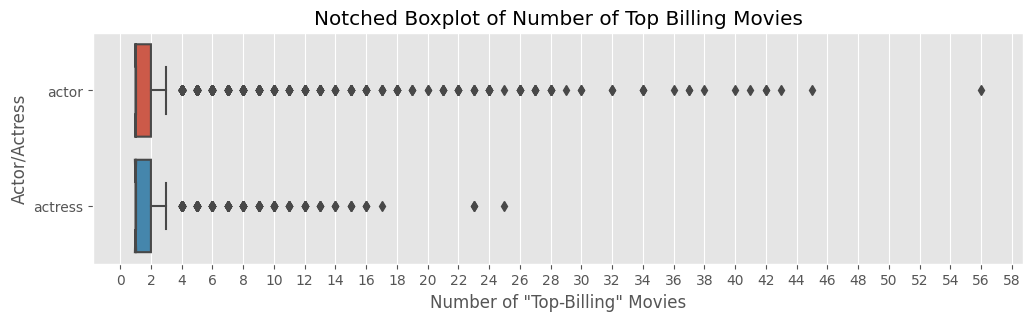

In [74]:
df = pd.read_sql("""SELECT NB.nconst, primaryname, category, count(*), DENSE_RANK() OVER (ORDER BY count(*) DESC) as top_billing_rank
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST  AND TP.ORDERING = 1
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST AND NKFT.ORDERING = 1
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000 GROUP BY NB.nconst, category""", db_URI)


import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 5))

sns.boxplot(x = 'count', y = 'category', data = df, ax = ax, notch = True)
ax.set_xlabel('Number of "Top-Billing" Movies')
ax.set_ylabel('Actor/Actress')
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.set_title('Notched Boxplot of Number of Top Billing Movies')

As we can see from the boxplot above, there is a larger disparity among actors and actresses when number of top-billing movies exceeds 17. 

**5.  Perform exporatory analysis of age distribution of movie actors and actresses within different film genres or release years.** <br>

In [81]:
df = pd.read_sql("""SELECT NB.nconst, primaryname, TB.tconst, primarytitle, category, birthyear, startyear, (startyear - birthyear) as age_at_startyear, 
CASE TP.ordering
        WHEN 1 THEN 'top-billing'
        ELSE 'non-lead'
END as top_billing_ind, TP.ordering, numvotes, averagerating, genre
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_GENRES TG ON TB.TCONST = TG.TCONST
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000""", db_URI)
df

,nconst,primaryname,tconst,primarytitle,category,birthyear,startyear,age_at_startyear,top_billing_ind,ordering,numvotes,averagerating,genre
0,nm0001273,Lillian Gish,tt0004972,The Birth of a Nation,actress,1893.0,1915,22.0,top-billing,1,25366,6.2,Drama
1,nm0001273,Lillian Gish,tt0004972,The Birth of a Nation,actress,1893.0,1915,22.0,top-billing,1,25366,6.2,Drama
2,nm0001273,Lillian Gish,tt0004972,The Birth of a Nation,actress,1893.0,1915,22.0,top-billing,1,25366,6.2,Drama
3,nm0001273,Lillian Gish,tt0004972,The Birth of a Nation,actress,1893.0,1915,22.0,top-billing,1,25366,6.2,Drama
4,nm0550615,Mae Marsh,tt0004972,The Birth of a Nation,actress,1894.0,1915,21.0,non-lead,2,25366,6.2,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417987,nm0000574,Jason Patric,tt9794630,The Vanished,actor,1966.0,2020,54.0,non-lead,3,11317,5.7,Horror
417988,nm7425091,Alex Haydon,tt9794630,The Vanished,actor,NaN,2020,NaN,non-lead,4,11317,5.7,Horror
417989,nm7425091,Alex Haydon,tt9794630,The Vanished,actor,NaN,2020,NaN,non-lead,4,11317,5.7,Horror
417990,nm7425091,Alex Haydon,tt9794630,The Vanished,actor,NaN,2020,NaN,non-lead,4,11317,5.7,Horror


Text(0.5, 1.0, 'Notched Boxplot of Age for "Top-Billing" vs. "Non-Lead"')

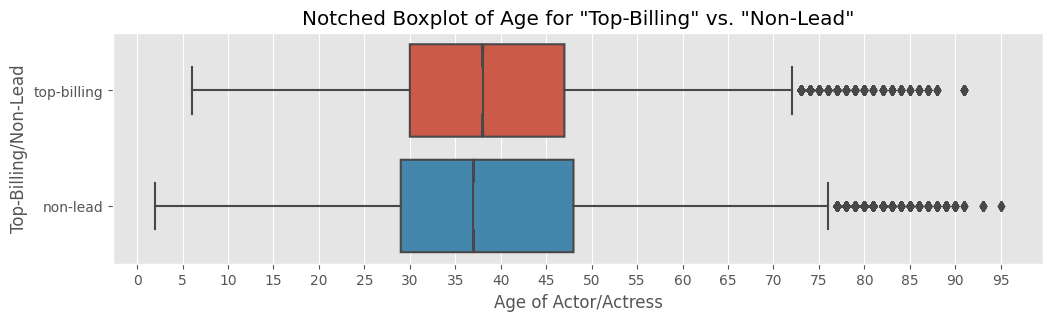

In [3]:
df = pd.read_sql("""WITH acting_age as (SELECT NB.nconst, primaryname, TB.tconst, primarytitle, category, birthyear, startyear, (startyear - birthyear) as age_at_startyear, 
CASE TP.ordering
        WHEN 1 THEN 'top-billing'
        ELSE 'non-lead'
END as top_billing_ind, TP.ordering, numvotes, averagerating, genre
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_GENRES TG ON TB.TCONST = TG.TCONST
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000) select * from acting_age where age_at_startyear < 100 AND age_at_startyear > 0""", db_URI)

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 3))

sns.boxplot(x = 'age_at_startyear', y = 'top_billing_ind', data = df, ax = ax, notch = True)
ax.set_xlabel('Age of Actor/Actress')
ax.set_ylabel('Top-Billing/Non-Lead')
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.set_title('Notched Boxplot of Age for "Top-Billing" vs. "Non-Lead"')

There does not appear to be much disparity among age with regards to top-billing vs. non-leading actors and actresses. There does appear to be less values on the extremeties of the top billing actors and actresses. 

C:\Users\malab\AppData\Roaming\Python\Python310\site-packages\seaborn\regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\Users\malab\AppData\Roaming\Python\Python310\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Age vs Average Rating')

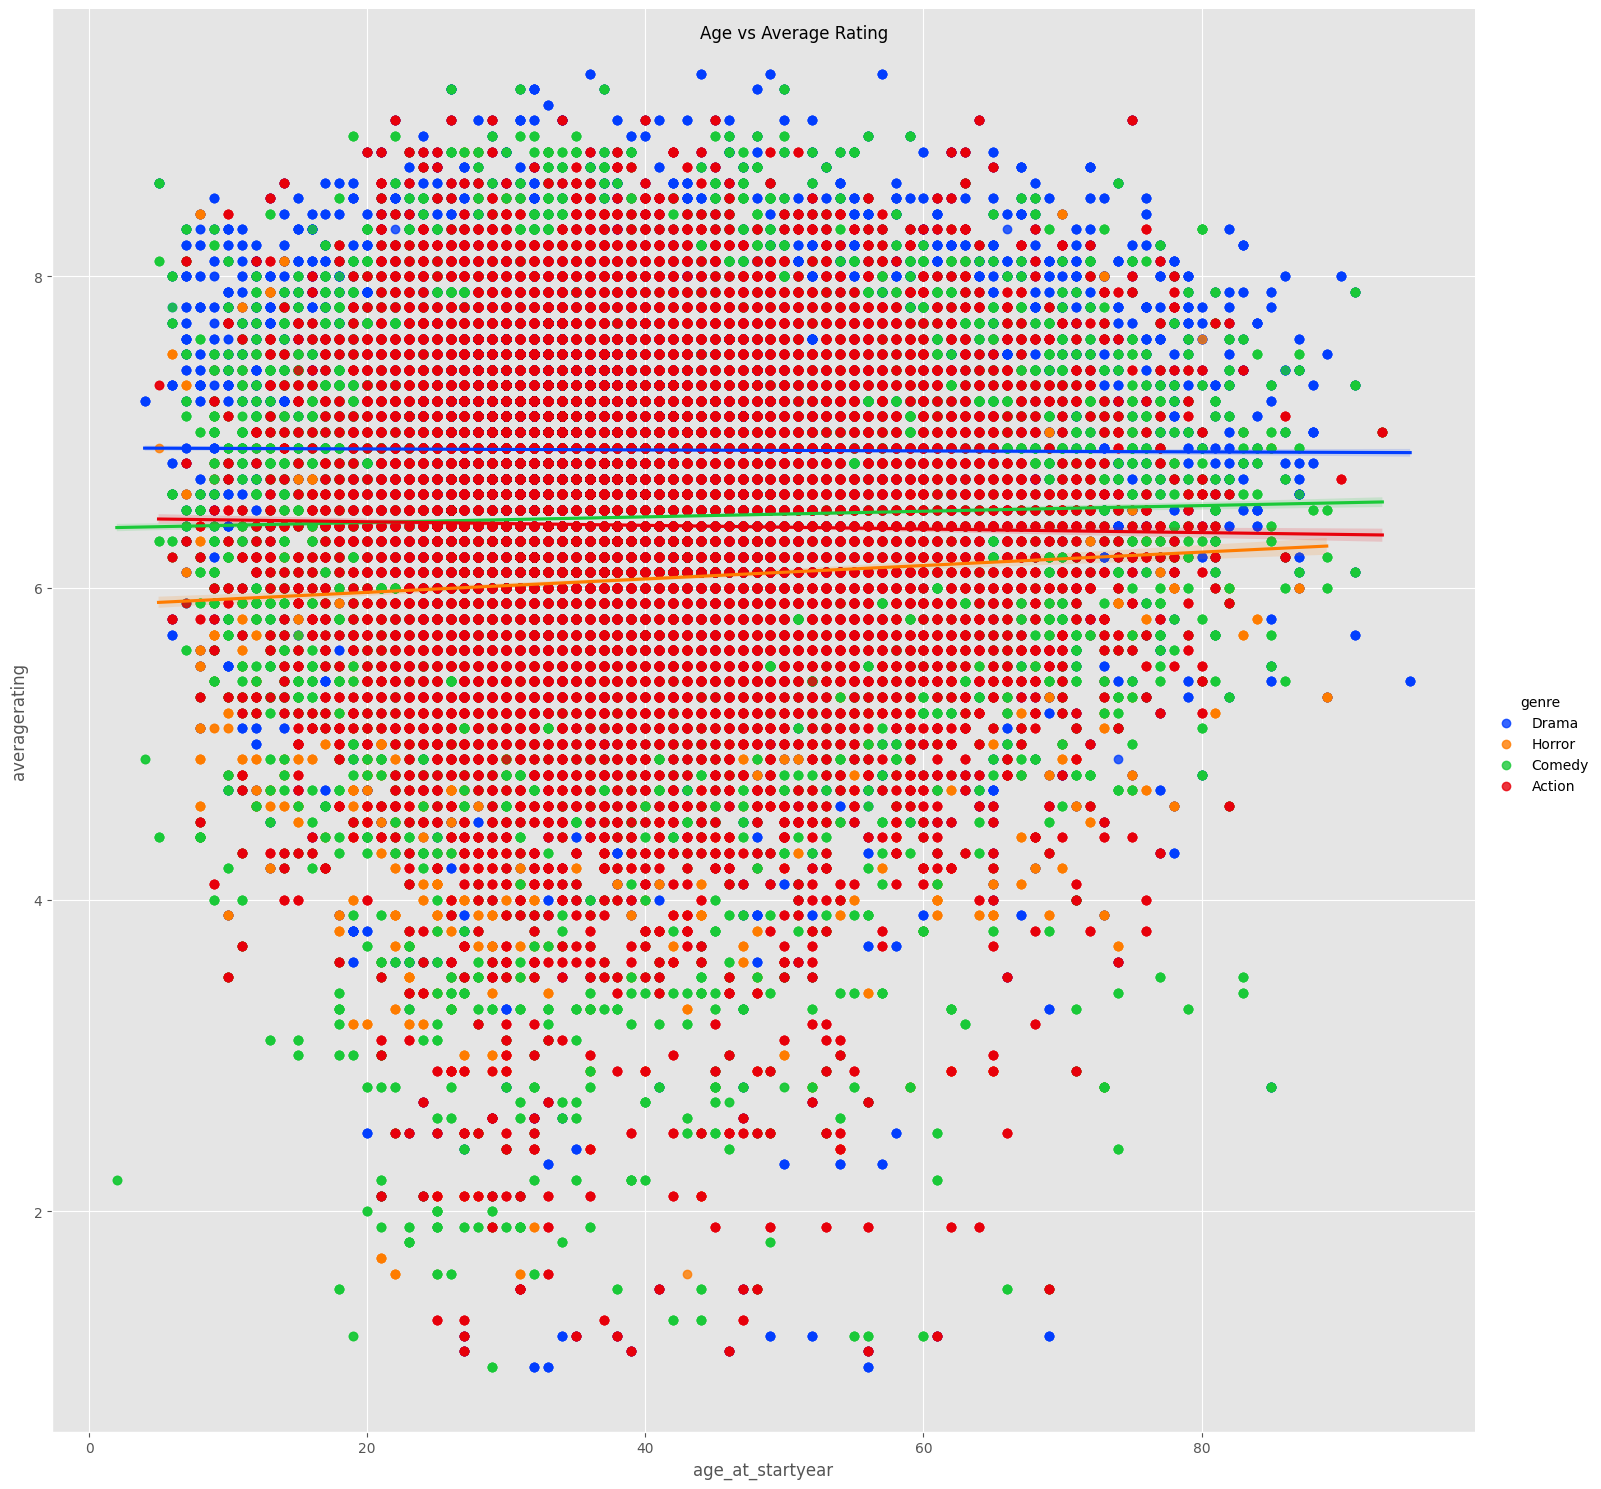

In [10]:
df = pd.read_sql("""WITH acting_age as (SELECT NB.nconst, primaryname, TB.tconst, primarytitle, category, birthyear, startyear, (startyear - birthyear) as age_at_startyear, 
CASE TP.ordering
        WHEN 1 THEN 'top-billing'
        ELSE 'non-lead'
END as top_billing_ind, TP.ordering, numvotes, averagerating, genre
FROM IMDB.TITLE_RATINGS TR 
INNER JOIN IMDB.TITLE_BASICS TB ON TB.TCONST = TR.TCONST 
INNER JOIN IMDB.TITLE_GENRES TG ON TB.TCONST = TG.TCONST
INNER JOIN IMDB.TITLE_PRINCIPALS TP ON TP.TCONST = TB.TCONST
INNER JOIN IMDB.NAME_BASICS NB ON NB.NCONST = TP.NCONST 
INNER JOIN IMDB.NAME_KNOWN_FOR_TITLE NKFT ON NKFT.NCONST = NB.NCONST
WHERE TITLETYPE = 'movie' AND CATEGORY LIKE 'act%%' AND NUMVOTES >= 10000) 
select * from acting_age where age_at_startyear < 100 AND age_at_startyear > 0 AND (genre = 'Action' OR genre = 'Drama' OR genre = 'Comedy' 
OR genre = 'Horror')""", db_URI)


lm = sns.lmplot(x='age_at_startyear', 
            y='averagerating',
            hue='genre',
            palette='bright',
            data=df,  
            sharex=True,
            sharey=True,
            height=15)

fig = lm.fig 
fig.suptitle("Age vs Average Rating", fontsize=12)

Comparing arguably the most popular/well-known movie genres, the age of the actor or actress has little effect on the averagerating overall. We do see a slight trend in horror and comedy movies increasing in averagerating as the age goes up. We also see a slight trend downward for action movies. Interestingly, drama movies were found to have roughly the same averagerating no matter the age of the actor or actress. 